# Experimenting with RNNs and LSTMs
The objective of this experiment is to demonstrate vanishing and exploding gradients in RNNs and LSTMs.
This would be accomplished by training the RNNs and LSTMs on artifically generated sequences of varying lengths, and recording various parameters related to model training and model performance.<br>
<br>
Specifically, the following parameters would be monitored: -<br>
1) Model performance (measured as MAD)
2) Model parameter gradients

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 8.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

import os
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
import json

from torch import nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset
from torch.utils.data.sampler import Sampler
import torch
import pytorch_lightning as pl

import random

In [3]:
torch.manual_seed(42)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

## 1) Loading and initializing wrangled data

In [4]:
def compute_acf(train_seq_arr, train_output_arr):
    """
    Computes the auto-correlation (ACF) of the output at a given time-stamp with respect to the outputs in the
    previous time-stamp i.e., the training sequence.

    Parameters: -
    - train_seq_arr (numpy 2D array): -    Each sub-array represents a lagged sequence.
    - train_output_arr (numpy 1D array): - Each value at a given index is the output associated with the sequence at the
                                           same index in 'train_seq_arr'.

    Returns: -
    - numpy 1D array: - Contains the Pearson correlation coefficient of the output with the lagged values in the training
                        sequence.
    """

    #Initialize the array containing the correlation coefficients.
    corr_arr = np.zeros(train_seq_arr.shape[1])

    #For each lagged value, compute the correlation of coefficient between the output and the lagged values in the
    #sequence.
    for lag_index in range(0, train_seq_arr.shape[1]):
        corr_arr[lag_index], _ = pearsonr(train_seq_arr[:, lag_index].flatten(), train_output_arr.flatten())

    return corr_arr

In [5]:
def gen_simple_input_sequences(seq_len = 5, num_seqs = 50000, num_range_low = 2000, num_range_high = 2000, std_dev = 2, seed_val = 42):
    """
    Get input sequences of specified length such that the output of each sequence is a perfect linear function of the
    input sequence elements.

    Parameters: -
    - seq_len (int): -        The length of the input sequence.
    - num_seqs (int): -       The number of input sequences to be created.
    - num_range_low (int): -  The lower limit of the randomly generated numbers that comprise the input sequences.
    - num_range_high (int): - The upper limit of the randomly generated numbers that comprise the input sequences.
    - seed_val (int): -       Seed value that makes input sequence generation deterministic.

    Returns: -
    - numpy 3D array: -       Contains the input sequences that have been generated.
    - numpy 2D array: -       Contains the outputs associated with the input sequences.
    - numpy 1D array: -       Contains the correlation (ACF) of the output with the lagged values (contained in
                              the input sequence).
    """
    random.seed(seed_val)

    #Weights to be applied to the input sequence to generate the associated output.
    weights = [0]*seq_len
    weights[0] = 0.6
    weights[seq_len-1] = 0.3

    #Initializing the array that will contain the input sequence.
    seq_arr = np.zeros((num_seqs, seq_len))

    #Initializing the array that will contain the outputs associated with the input sequence.
    output_arr = np.zeros(num_seqs)

    #Iteratively, generate sequences.
    for seq_index in range(num_seqs):

        #Iteratively, generate the individual numbers that comprise the input sequence.
        #compute the output associated with the current input sequence.
        output = 0
        for element_index in range(seq_len):

            seq_arr[seq_index, element_index] = random.randint(num_range_low, num_range_high)

            if weights[element_index] != 0:
                output += seq_arr[seq_index, element_index] * weights[element_index] + random.gauss(0, std_dev)

            output += seq_arr[seq_index, element_index] * weights[element_index]

        #Store the output associated with the input sequence.
        output_arr[seq_index] = output

    #Compute the ACF of the outputs with their associated input sequences.
    corr_arr = compute_acf(seq_arr[0:500], output_arr[0:500])

    #Turn the input sequence into a 3D array.
    seq_arr = seq_arr.reshape((seq_arr.shape[0], seq_arr.shape[1], 1))

    return seq_arr, output_arr.reshape((-1, 1)), corr_arr

In [ ]:
train_seq_arr, train_output_arr, corr_arr = gen_simple_input_sequences(seq_len = 6, num_seqs = 1000, num_range_low = -50, num_range_high = 50)

In [6]:
def gen_realistic_input_sequences(seq_len = 5, num_seqs = 50000, num_range_low = 2000, num_range_high = 2000, std_dev = 2, seed_val = 42):
    """
    Generates realistic input sequences and associated outputs based on a linear combination
    of previous numbers in the sequence with added noise.

    Parameters:
    - seq_len (int): The length of each input sequence.
    - num_seqs (int): The total number of sequences to generate.
    - num_range_low (int): The lower bound for random number generation.
    - num_range_high (int): The upper bound for random number generation.
    - std_dev (float): Standard deviation for the Gaussian noise added to the output.
    - seed_val (int): Seed value for random number generation to ensure reproducibility.

    Returns:
    - seq_arr (numpy.ndarray): 3D array of shape (num_seqs, seq_len, 1) containing the generated input sequences.
    - output_arr (numpy.ndarray): 2D array of shape (num_seqs, 1) containing the associated outputs for each sequence.
    - corr_arr (numpy.ndarray): 1D array containing the auto-correlation coefficients for the first 500 sequences.
    """

    random.seed(seed_val)

    #Weights to be applied to the input sequence to generate the associated output.
    weights = [0]*seq_len
    weights[0] = 0.7
    weights[seq_len-1] = 0.3

    num_of_nums = seq_len + num_seqs      #Total number of numbers that need to be generated.
    num_arr = np.zeros(num_of_nums)       #Create an array to store all the numbers.

    #Initializing the array that will contain the input sequence.
    seq_arr = np.zeros((num_seqs, seq_len))

    #Initializing the array that will contain the outputs associated with the input sequence.
    output_arr = np.zeros(num_seqs)

    #Initializing the array that will contain the input sequence.
    seq_arr = np.zeros((num_seqs, seq_len))

    #The first 'seq_len' numbers will be randomly generated.
    for index in range(seq_len):
        num_arr[index] = random.randint(num_range_low, num_range_high)

    seq_index = 0

    #Generate the remaining numbers as linear combination of the previous 'seq_len' numbers.
    for index1 in range(seq_len, num_of_nums):

        curr_seq_arr = np.zeros(seq_len)

        element_index = 0

        for index2 in range(index1-seq_len, index1):

            curr_seq_arr[element_index] = num_arr[index2]

            if weights[element_index] != 0:
                num_arr[index1] += weights[element_index] * num_arr[index2] + random.gauss(0, std_dev)

            element_index += 1

        #This is the current sequence
        seq_arr[seq_index] = curr_seq_arr

        #This is the output for the current sequence.
        output_arr[seq_index] = num_arr[index1]

        seq_index += 1

    corr_arr = compute_acf(seq_arr[0:500], output_arr[0:500])
    seq_arr = seq_arr.reshape((seq_arr.shape[0], seq_arr.shape[1], 1))

    return seq_arr, output_arr.reshape((-1, 1)), corr_arr

In [ ]:
train_seq_arr, train_output_arr, corr_arr = gen_realistic_input_sequences(seq_len = 5, num_seqs = 1000, num_range_low = -50, num_range_high = 50)

## 2) Function for LSTM models

### 2.1) Class that instantiates LSTM model

In [7]:
class LSTMModel(nn.Module):
    """
    A PyTorch LSTM model for sequence prediction. It contains an LSTM layer followed by a fully connected layer
    for generating final predictions.
    """

    def __init__(self, input_size, hidden_size, num_layers, num_preds):
        """
        Initializes the LSTM model with the specified parameters.

        Parameters:
        - input_size (int): The number of input features.
        - hidden_size (int): The number of features in the hidden state.
        - num_layers (int): The number of recurrent layers in the LSTM.
        - num_preds (int): The number of predictions to output from the fully connected layer.
        """
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Fully connected layer for final prediction
        self.fc = nn.Linear(hidden_size, num_preds)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
        - torch.Tensor: Output predictions of shape (batch_size, num_preds)
        """

        #Initialize hidden state and cell state for LSTM with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        #Perform LSTM forward pass, returns output and hidden states
        out, _ = self.lstm(x, (h0, c0))

        #Select the last time step's output
        out = out[:, -1, :]

        #Pass through the fully connected layer to get final predictions
        out = self.fc(out)

        return out

    def get_num_params(self):
        """
        Returns the total number of parameters in the model.

        Returns:
        - int: Total parameter count
        """

        return sum(p.numel() for p in self.parameters())

In [8]:
class RNNModel(nn.Module):
    """
    A simple PyTorch RNN model for sequence prediction. It consists of an RNN layer followed by a fully connected
    layer for producing final predictions.
    """

    def __init__(self, input_size, hidden_size, num_layers, num_preds):
        """
        Initializes the RNN model with the specified parameters.

        Parameters:
        - input_size (int): The number of input features per time step.
        - hidden_size (int): The number of features in the hidden state.
        - num_layers (int): The number of recurrent layers in the RNN.
        - num_preds (int): The number of predictions to output from the fully connected layer.
        """
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # RNN layer
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)

        # Fully connected layer for final prediction
        self.fc = nn.Linear(hidden_size, num_preds)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
        - torch.Tensor: Output predictions of shape (batch_size, num_preds)
        """

        #Initialize hidden state for RNN with zeros.
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        #Perform RNN forward pass, returns output and last hidden state.
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

    def get_num_params(self):
        """
        Returns the total number of parameters in the model.

        Returns:
        - int: Total parameter count
        """

        return sum(p.numel() for p in self.parameters())

### 2.2) Function to train the model for one epoch

In [9]:
def compute_grad_mean(model):
    """
    Computes the mean of the absolute gradients for specific parameters (input-hidden weights,
    hidden-hidden weights, and biases) in a given model. This function only includes parameters
    with gradients and ignores parameters without them.

    Parameters:
    - model (torch.nn.Module): The model for which to compute the mean gradient value.

    Returns:
    - float: The mean of the absolute gradients across all specified parameters in the model.
    """

    # Initialize variables to store total gradient sum and count of gradient tensors
    total_grads = 0
    grad_count = 0

     # Iterate through model parameters by name and tensor
    for name, param in model.named_parameters():

        # Select only specific parameters: weights and biases for input-hidden and hidden-hidden layers
        if (('weight_ih' in name) or ('weight_hh' in name) or ('bias_ih' in name) or ('bias_hh' in name)):

            #Check if the gradient for this parameter is not None
            if param.grad is not None:

                #Accumulate the mean absolute gradient for the parameter
                total_grads += param.grad.abs().mean().item()  # Mean absolute gradient for each parameter

                #Count total number of parameter tensors
                grad_count += 1

    #Compute and return the average of the absolute gradients.
    return total_grads/grad_count

In [10]:
def train_one_epoch(model, loss_function, optimizer, epoch, dataset_loader):
    """
    Trains the model for one epoch.

    Parameters:
    - model (torch.nn.Module): The neural network model to train.
    - loss_function (function): The loss function to compute the error between the model output and target.
    - optimizer (torch.optim.Optimizer): The optimizer to update the model parameters.
    - epoch (int): The current epoch number, used for logging or tracking purposes.
    - dataset_loader (torch.utils.data.DataLoader): DataLoader providing batches of input features and labels.

    Returns:
    - float: The average loss per batch, rounded to 3 decimal places.
    - float: The mean absolute gradient of selected parameters in the model.
    """
    #Set the model to training mode.
    model.train(True)

    #Initialize total loss and average loss trackers.
    total_loss = 0
    avg_loss = 0

    #Iterate over each batch in the dataset.
    for batch_index, batch in enumerate(dataset_loader):
        batch_features = batch[0]  #Extract features from batch
        batch_labels = batch[1]    #Extract labels from batch

        #Forward pass: Compute model output
        output = model(batch_features)

        #Compute the loss for the current batch
        batch_loss = loss_function(output, batch_labels)
        total_loss += batch_loss.item()

        #Backward pass: Zero gradients, compute gradient, and update model weights
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    return round((total_loss/len(dataset_loader)), 3), compute_grad_mean(model)

### 2.3) Function to validate the model after one epoch

In [11]:
def validate_one_epoch(model, loss_function, val_dataset):
    """
    Validates the model for one epoch without updating weights.

    Parameters:
    - model (torch.nn.Module): The neural network model to evaluate.
    - loss_function (function): The loss function to compute the error between the model output and target.
    - val_dataset (torch.utils.data.Dataset): Dataset containing validation data.

    Returns:
    - float: The average loss over the validation dataset.
    """

    #Set the model to evaluation mode
    model.train(False)

    #Initialize total loss accumulator and batch counter
    total_loss = 0

    #Disable gradient computation for validation
    count = 0
    with torch.no_grad():

        #Perform forward pass on the entire validation dataset at once
        output = model(val_dataset[:][0])
        batch_loss = loss_function(output, val_dataset[:][1])
        total_loss += batch_loss.item()

        count += 1

    #Return the average validation loss
    return total_loss/count

### 2.4) Function to build and train the models.

In [12]:
def build_and_train_models(train_dataset, val_dataset, learning_rate, hidden_size_list, num_layer_list, input_size, num_epochs = 10, model_type = 1, patience = 2, verbose = False):
    """
    Builds and trains a series of RNN or LSTM models with varying hidden sizes and layer counts.
    Uses early stopping based on validation loss to prevent overfitting.

    Parameters:
    - train_dataset (torch.utils.data.Dataset): Training dataset.
    - val_dataset (torch.utils.data.Dataset): Validation dataset.
    - learning_rate (float): Learning rate for the optimizer.
    - hidden_size_list (list): List of hidden sizes to try.
    - num_layer_list (list): List of layer counts to try.
    - input_size (int): Dimensionality of the input data.
    - num_epochs (int, optional): Number of epochs to train each model. Default is 10.
    - model_type (int, optional): Model type to build, 1 for LSTMModel, otherwise RNNModel.
    - patience (int, optional): Number of epochs to wait before early stopping if no improvement. Default is 2.
    - verbose (bool, optional): Whether to print detailed progress. Default is False.

    Returns:
    - tuple: Best validation mean absolute deviation (MAD) across models and mean gradient across epochs.
    """

    best_val_mad = None

    for hidden_size in hidden_size_list:

        for num_layer in num_layer_list:

            val_gt_prev_epochs_count = patience

            if model_type == 1:

                #Instantiate the model
                model = LSTMModel(input_size, hidden_size = hidden_size, num_layers = num_layer, num_preds = 1)

            else:
                #Instantiate the model
                model = RNNModel(input_size, hidden_size = hidden_size, num_layers = num_layer, num_preds = 1)

            if verbose == True:
                print(f'Model with hidden size = {hidden_size}, number of layers = {num_layer}, number of parameters = {model.get_num_params()}')

            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            loss_function = nn.L1Loss()

            train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

            mean_grad_across_epochs = 0
            for epoch in range(1, num_epochs+1):

                train_mad, mean_grad = train_one_epoch(model, loss_function, optimizer, epoch, train_dataset_loader)
                mean_grad_across_epochs += mean_grad
                val_mad = validate_one_epoch(model, loss_function, val_dataset)

                if best_val_mad is None:
                    best_val_mad = val_mad

                elif best_val_mad > val_mad:
                    best_val_mad = val_mad
                    val_gt_prev_epochs_count = patience

                else:
                    if val_gt_prev_epochs_count > 0:
                        val_gt_prev_epochs_count -= 1

                    else:
                        break

                if verbose == True:
                    print(f'Epoch {epoch}: Training loss = {train_mad}, Validation loss = {val_mad}')

            mean_grad_across_epochs /= num_epochs
            print(f'\nMean gradient across epochs = {mean_grad_across_epochs}')

    return best_val_mad, mean_grad_across_epochs

In [13]:
def prep_input_seqs_dataset(train_seq_arr, train_output_arr):
    """
    Prepares the input sequences and outputs for training by converting them into a PyTorch dataset.

    Parameters:
    - train_seq_arr (numpy.ndarray): 2D array where each row is a sequence used as input for training.
    - train_output_arr (numpy.ndarray): 1D array where each element is the output associated with the corresponding sequence.

    Returns:
    - TensorDataset: A PyTorch dataset containing the input sequences and corresponding outputs as tensors.
    """

    #Converting training and output numpy arrays to tensors.
    train_seq_tensor = torch.tensor(train_seq_arr).float()
    train_output_tensor = torch.tensor(train_output_arr).float()

    train_dataset = TensorDataset(train_seq_tensor, train_output_tensor)

    return train_dataset

In [14]:
def build_and_train_models_across_grid(seq_type, seq_len_list, normalize, data_lower_lim, data_upper_lim, noise_std_dev):

    lstm_val_loss_dict = {}
    lstm_grad_dict = {}

    rnn_val_loss_dict = {}
    rnn_grad_dict = {}

    for seq_len in seq_len_list:

        print(f'\nSequence length = {seq_len}')

        #Generate a simple sequence.
        if seq_type == 'S':
            train_seq_arr, train_output_arr, corr_arr = gen_simple_input_sequences(seq_len = seq_len, num_seqs = 25000, num_range_low = data_lower_lim, num_range_high = data_upper_lim, std_dev = noise_std_dev, seed_val = 42)

        #Generate a realistic sequence.
        else:
            train_seq_arr, train_output_arr, corr_arr = gen_realistic_input_sequences(seq_len = seq_len, num_seqs = 25000, num_range_low = data_lower_lim, num_range_high = data_upper_lim, std_dev = noise_std_dev, seed_val = 42)

        if normalize == True:
            mean = np.mean(train_seq_arr)
            std_dev = np.std(train_seq_arr)
            train_seq_arr = (train_seq_arr - mean)/std_dev

        if seq_len > 10:
            print('Correlation of target with lagged values: -\n', corr_arr[0:5], '...', corr_arr[-5:])
        else:
            print('Correlation of target with lagged values: -\n', corr_arr)

        #Generate a simple sequence.
        if seq_type == 'S':
            val_seq_arr, val_output_arr, _ = gen_simple_input_sequences(seq_len = seq_len, num_seqs = 1000, num_range_low = data_lower_lim, num_range_high = data_upper_lim, std_dev = 0, seed_val = 43)

        #Generate a realistic sequence.
        else:
            val_seq_arr, val_output_arr, _ = gen_realistic_input_sequences(seq_len = seq_len, num_seqs = 1000, num_range_low = data_lower_lim, num_range_high = data_upper_lim, std_dev = 0, seed_val = 43)

        if normalize == True:
            val_seq_arr = (val_seq_arr - mean)/std_dev

        train_dataset = prep_input_seqs_dataset(train_seq_arr, train_output_arr)
        val_dataset = prep_input_seqs_dataset(val_seq_arr, val_output_arr)

        lstm_val_loss_dict[seq_len], lstm_grad_dict[seq_len] = build_and_train_models(train_dataset, val_dataset, LEARNING_RATE, hidden_size_list1, num_layer_list, input_size, num_epochs = NUM_EPOCHS, model_type = 1, patience = 3, verbose = False)
        print(f'Best LSTM validation loss = {lstm_val_loss_dict[seq_len]}')

        rnn_val_loss_dict[seq_len], rnn_grad_dict[seq_len] = build_and_train_models(train_dataset, val_dataset, LEARNING_RATE, hidden_size_list2, num_layer_list, input_size, num_epochs = NUM_EPOCHS, model_type = 2, patience = 3, verbose = False)
        print(f'Best RNN validation loss = {rnn_val_loss_dict[seq_len]}')

        print('------------------------------------')

    return lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict

## 3) Training on simple sequences - noise-free input
- Unnormalized sequences (of varying lengths)

### 3.1) Setting model parameters and hyper-parameters

In [18]:
input_size = 1

num_layer_list = [1]
hidden_size_list1= [6] #[4, 8, 16, 32]
hidden_size_list2= [6] #[4, 8, 16, 32]
num_preds = 1

NUM_EPOCHS = 20
LEARNING_RATE = 0.01

### 3.2) Creating input sequences, models, and training the model

In [1]:
seq_len_list = [seq_len for seq_len in range(2, 15, 1)] + [seq_len for seq_len in range(15, 30, 2)] + [seq_len for seq_len in range(30, 46, 3)]
data_lower_lim = -50
data_upper_lim = 50

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 0)


Sequence length = 2
Correlation of target with lagged values: -
 [0.89319597 0.4561776 ]

Mean gradient across epochs = 3.6125610443763434
Best LSTM validation loss = 0.7097107172012329

Mean gradient across epochs = 9.364313413947821
Best RNN validation loss = 0.8537089228630066
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.89303242 -0.01629563  0.44697193]

Mean gradient across epochs = 2.859679163992405
Best LSTM validation loss = 1.1328091621398926

Mean gradient across epochs = 24.70320195928216
Best RNN validation loss = 2.6792523860931396
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [ 0.89524877  0.02579215 -0.0077563   0.43270521]

Mean gradient across epochs = 3.933165462873876
Best LSTM validation loss = 1.4940376281738281

Mean gradient across epochs = 36.76803224533796
Best RNN validation loss = 2.9038515090942383
------------------------------------

Sequ

### 3.3) Plot MADs for varying sequences for LSTM as well as RNN

In [15]:
def plot_mad(lstm_val_loss_dict, rnn_val_loss_dict):

    lstm_x_vals = list(lstm_val_loss_dict.keys())
    lstm_y_vals = list(lstm_val_loss_dict.values())
    plt.plot(lstm_x_vals, lstm_y_vals, marker='o', linestyle='-', label='LSTM validation loss')

    rnn_x_vals = list(rnn_val_loss_dict.keys())
    rnn_y_vals = list(rnn_val_loss_dict.values())
    plt.plot(rnn_x_vals, rnn_y_vals, marker='o', linestyle='-', label='RNN validation loss')

    plt.xlabel('Sequence length')
    plt.ylabel('Validation loss')
    plt.title('Validation Loss vs sequence length')

    plt.legend()

    plt.grid(True)
    plt.show()

In [16]:
def plot_grad(lstm_grad_dict, rnn_grad_dict):

    lstm_x_vals = list(lstm_grad_dict.keys())
    lstm_y_vals = list(lstm_grad_dict.values())
    plt.plot(lstm_x_vals, lstm_y_vals, marker='o', linestyle='-', label='LSTM mean gradient')

    rnn_x_vals = list(rnn_grad_dict.keys())
    rnn_y_vals = list(rnn_grad_dict.values())
    plt.plot(rnn_x_vals, rnn_y_vals, marker='o', linestyle='-', label='RNN mean gradient')

    plt.xlabel('Sequence length')
    plt.ylabel('Parameter gradient')
    plt.title('Parameter gradient vs sequence length')

    plt.legend()

    plt.grid(True)
    plt.show()

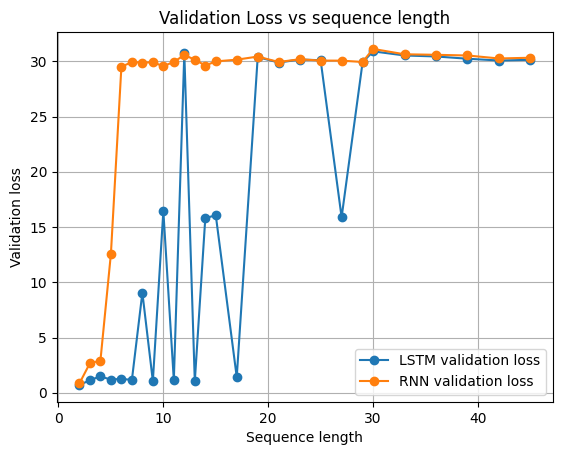

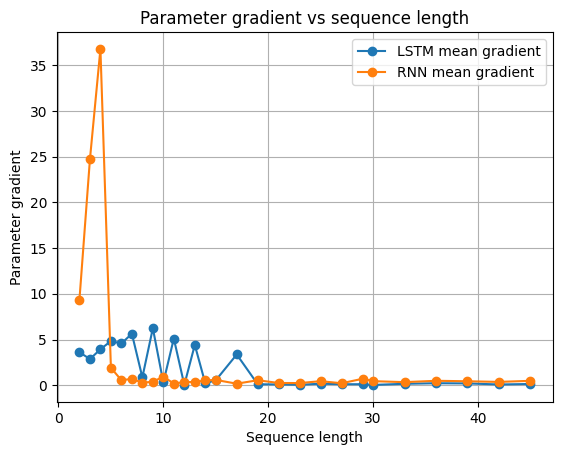

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 4) Training on simple sequences - noisy input (standard deviation = 2)
- Unnormalized sequences (of varying lengths)

### 4.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 4.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 2)


Sequence length = 2
Correlation of target with lagged values: -
 [0.89185406 0.45150119]

Mean gradient across epochs = 2.7703013964928687
Best LSTM validation loss = 1.2881821393966675

Mean gradient across epochs = 6.109498069807887
Best RNN validation loss = 1.957363247871399
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.88985911 -0.01362661  0.44620393]

Mean gradient across epochs = 2.878466092888266
Best LSTM validation loss = 1.4519503116607666

Mean gradient across epochs = 20.85177766531706
Best RNN validation loss = 2.508776903152466
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [ 0.89359808  0.02792656 -0.00347772  0.43047345]

Mean gradient across epochs = 3.3929066002368926
Best LSTM validation loss = 2.0633554458618164

Mean gradient across epochs = 1.2098898467142134
Best RNN validation loss = 12.384377479553223
------------------------------------

Sequ

### 4.3) Plot MADs for varying sequences for LSTM as well as RNN

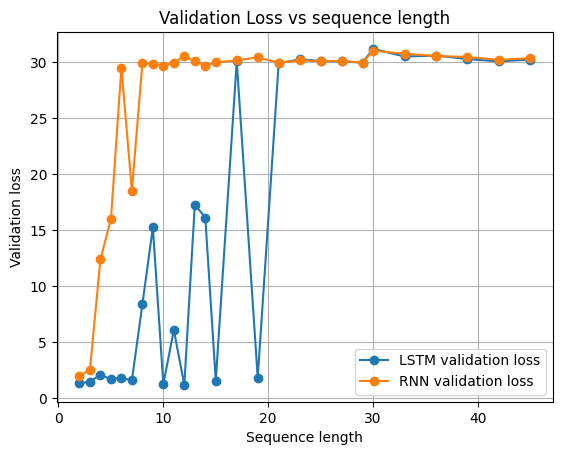

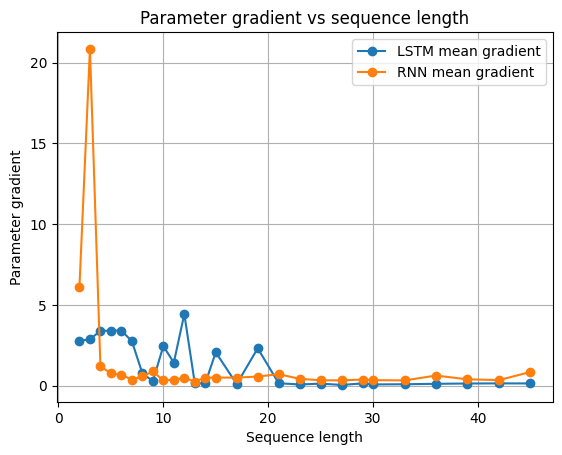

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 5) Training on simple sequences - noisy input (standard deviation = 4)
- Unnormalized sequences (of varying lengths)

### 5.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 5.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 4)


Sequence length = 2
Correlation of target with lagged values: -
 [0.88477845 0.44398021]

Mean gradient across epochs = 1.112994562322274
Best LSTM validation loss = 2.0444886684417725

Mean gradient across epochs = 6.748205649107694
Best RNN validation loss = 2.1071348190307617
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.88127168 -0.01093173  0.44270318]

Mean gradient across epochs = 1.8767259259708227
Best LSTM validation loss = 2.8598520755767822

Mean gradient across epochs = 10.455775948241353
Best RNN validation loss = 3.3833260536193848
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [8.87576543e-01 2.99068596e-02 7.83643529e-04 4.26147624e-01]

Mean gradient across epochs = 3.03585945116356
Best LSTM validation loss = 2.5545401573181152

Mean gradient across epochs = 1.3507688585668802
Best RNN validation loss = 8.097352981567383
------------------------------

### 5.3) Plot MADs for varying sequences for LSTM as well as RNN

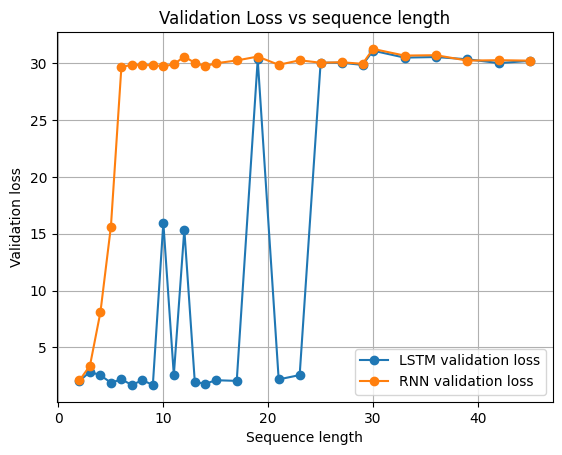

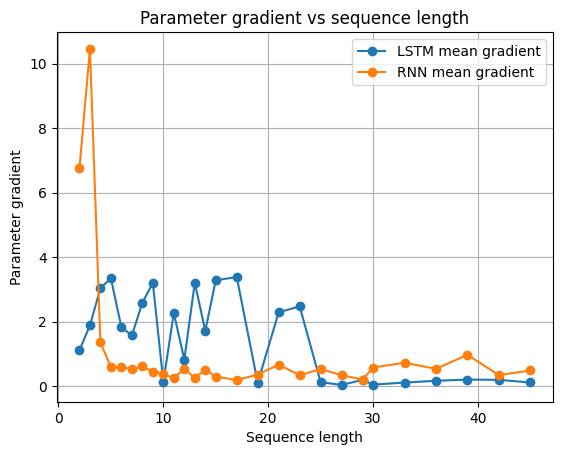

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 6) Training on simple sequences - noisy input (standard deviation = 6)
- Unnormalized sequences (of varying lengths)

### 6.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 6.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 6)


Sequence length = 2
Correlation of target with lagged values: -
 [0.87245271 0.43393112]

Mean gradient across epochs = 1.2869703765958547
Best LSTM validation loss = 2.2788665294647217

Mean gradient across epochs = 7.71605342850089
Best RNN validation loss = 2.0289337635040283
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.86786348 -0.00826294  0.43675376]

Mean gradient across epochs = 2.269369043316692
Best LSTM validation loss = 3.173468589782715

Mean gradient across epochs = 9.85640427544713
Best RNN validation loss = 3.879223108291626
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.8774371  0.03171013 0.00496657 0.41986984]

Mean gradient across epochs = 2.999672260787338
Best LSTM validation loss = 3.5686841011047363

Mean gradient across epochs = 0.451821324264165
Best RNN validation loss = 15.638772964477539
------------------------------------

Sequence len

### 6.3) Plot MADs for varying sequences for LSTM as well as RNN

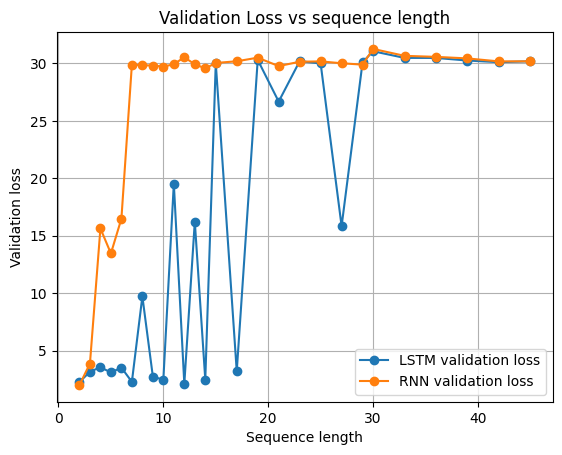

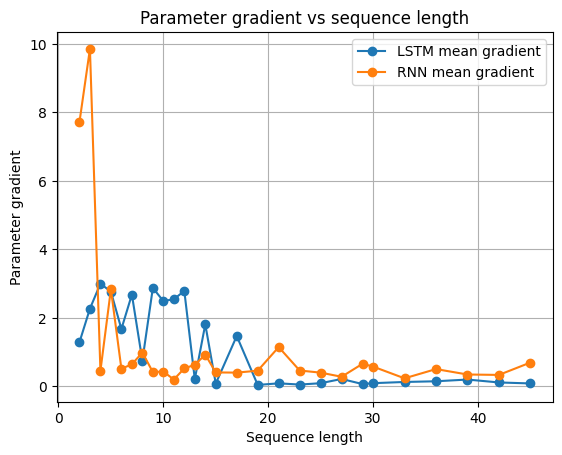

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 7) Training on simple sequences - noise-free input
- Normalized sequences (of varying lengths)

### 7.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 7.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 0)


Sequence length = 2
Correlation of target with lagged values: -
 [0.89319597 0.4561776 ]

Mean gradient across epochs = 0.668488862644881
Best LSTM validation loss = 0.1377793699502945

Mean gradient across epochs = 7.187622426450252
Best RNN validation loss = 0.16582326591014862
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.89303242 -0.01629563  0.44697193]

Mean gradient across epochs = 0.7156947419047356
Best LSTM validation loss = 0.23584811389446259

Mean gradient across epochs = 17.420661284774543
Best RNN validation loss = 0.7961476445198059
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [ 0.89524877  0.02579215 -0.0077563   0.43270521]

Mean gradient across epochs = 0.5103818573988974
Best LSTM validation loss = 0.8405173420906067

Mean gradient across epochs = 7.068042305111885
Best RNN validation loss = 1.0088064670562744
------------------------------------



### 7.3) Plot MADs for varying sequences for LSTM as well as RNN

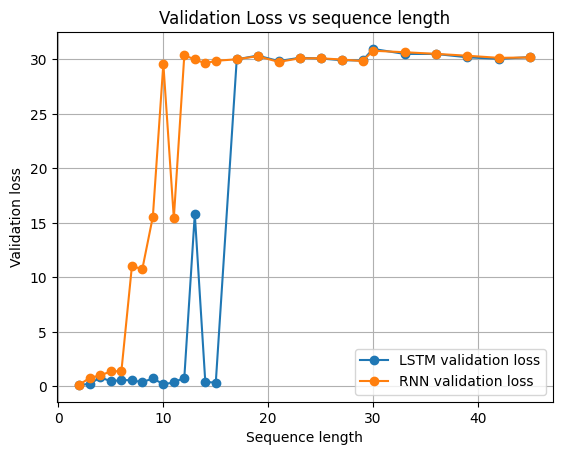

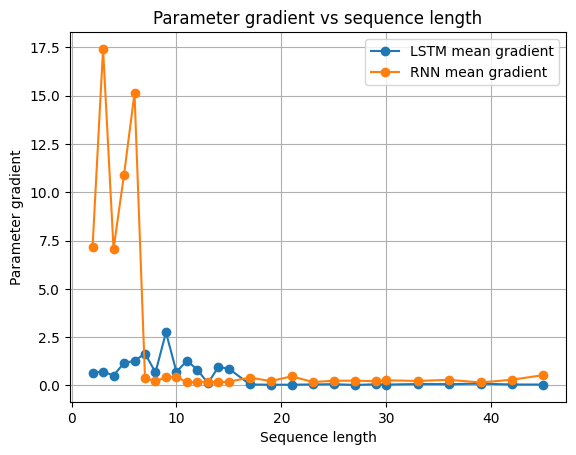

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 8) Training on simple sequences - noisy input (standard deviation = 2)
- Normalized sequences (of varying lengths)

### 8.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 8.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 2)


Sequence length = 2
Correlation of target with lagged values: -
 [0.89185406 0.45150119]

Mean gradient across epochs = 0.3444941469468176
Best LSTM validation loss = 0.6198700666427612

Mean gradient across epochs = 1.6801054567098617
Best RNN validation loss = 0.6098248362541199
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.88985911 -0.01362661  0.44620393]

Mean gradient across epochs = 0.7310870930552482
Best LSTM validation loss = 0.6955930590629578

Mean gradient across epochs = 4.50363197773695
Best RNN validation loss = 1.1399681568145752
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [ 0.89359808  0.02792656 -0.00347772  0.43047345]

Mean gradient across epochs = 1.023533166013658
Best LSTM validation loss = 0.7001486420631409

Mean gradient across epochs = 8.619881965219975
Best RNN validation loss = 2.812941312789917
------------------------------------

Sequ

### 8.3) Plot MADs for varying sequences for LSTM as well as RNN

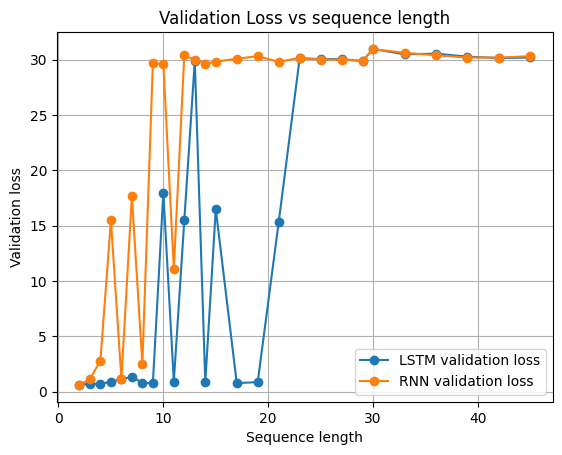

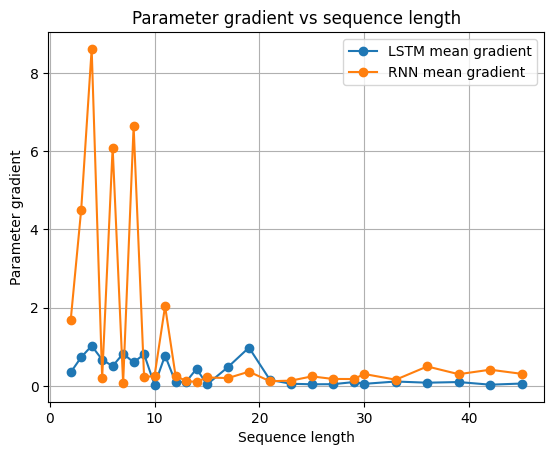

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 9) Training on simple sequences - noisy input (standard deviation = 4)
- Normalized sequences (of varying lengths)

### 9.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 9.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 4)


Sequence length = 2
Correlation of target with lagged values: -
 [0.88477845 0.44398021]

Mean gradient across epochs = 0.42547533293254675
Best LSTM validation loss = 0.8659130930900574

Mean gradient across epochs = 2.4531639575958253
Best RNN validation loss = 0.7372098565101624
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.88127168 -0.01093173  0.44270318]

Mean gradient across epochs = 0.7706921447068453
Best LSTM validation loss = 0.9533432126045227

Mean gradient across epochs = 4.341370262205601
Best RNN validation loss = 1.3577510118484497
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [8.87576543e-01 2.99068596e-02 7.83643529e-04 4.26147624e-01]

Mean gradient across epochs = 0.5483396089635789
Best LSTM validation loss = 1.2936383485794067

Mean gradient across epochs = 7.41887115240097
Best RNN validation loss = 1.513874888420105
----------------------------

### 9.3) Plot MADs for varying sequences for LSTM as well as RNN

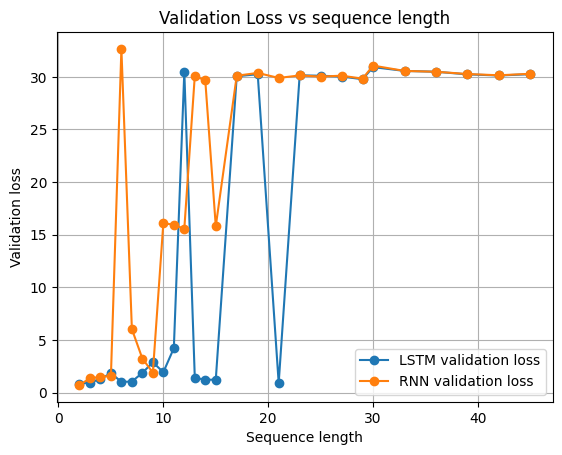

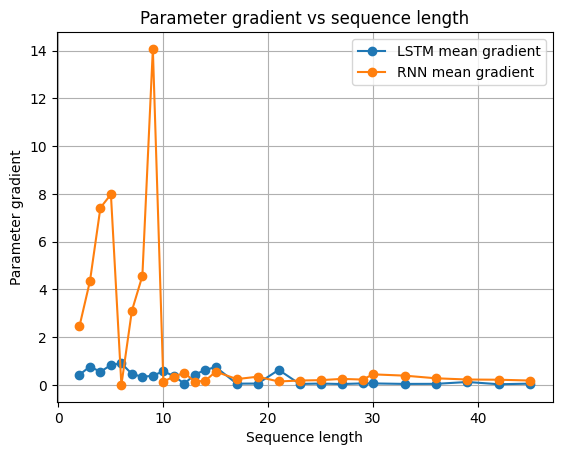

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 10) Training on simple sequences - noisy input (standard deviation = 6)
- Normalized sequences (of varying lengths)

### 10.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 10.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'S', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 6)


Sequence length = 2
Correlation of target with lagged values: -
 [0.87245271 0.43393112]

Mean gradient across epochs = 0.17635670145973564
Best LSTM validation loss = 1.3474005460739136

Mean gradient across epochs = 4.21690070182085
Best RNN validation loss = 1.7609282732009888
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.86786348 -0.00826294  0.43675376]

Mean gradient across epochs = 0.6881281657144427
Best LSTM validation loss = 0.9807695150375366

Mean gradient across epochs = 6.211154914647341
Best RNN validation loss = 1.8431873321533203
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.8774371  0.03171013 0.00496657 0.41986984]

Mean gradient across epochs = 0.564674430899322
Best LSTM validation loss = 1.4601079225540161

Mean gradient across epochs = 4.094482271373272
Best RNN validation loss = 2.3195667266845703
------------------------------------

Sequenc

### 10.3) Plot MADs for varying sequences for LSTM as well as RNN

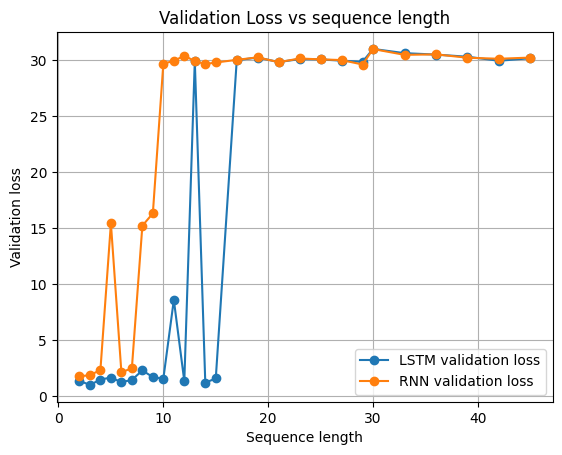

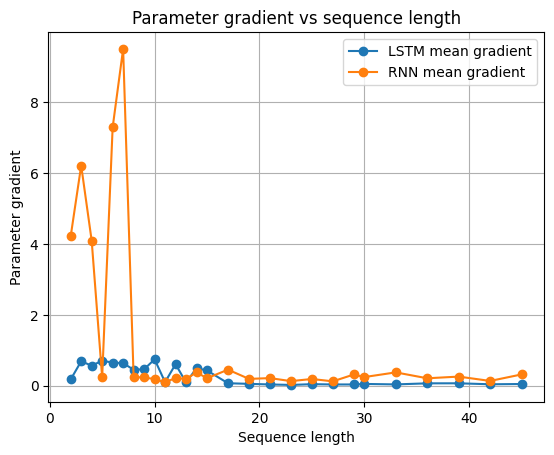

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 11) Training on realistic sequences - noise-free input
- Unnormalized sequences (of varying lengths)

### 11.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 11.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 0)


Sequence length = 2
Correlation of target with lagged values: -
 [ 1. -1.]

Mean gradient across epochs = 0.00039613939716218736
Best LSTM validation loss = 18.757230758666992

Mean gradient across epochs = 0.00016136494123202282
Best RNN validation loss = 18.75896644592285
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.97162556 -0.61514524 -0.56581031]

Mean gradient across epochs = 0.00011935380357499525
Best LSTM validation loss = 19.277189254760742

Mean gradient across epochs = 0.0001241786427272018
Best RNN validation loss = 17.712465286254883
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [ 0.9424864  -0.31162411 -0.9426028   0.18804063]

Mean gradient across epochs = 0.0010762054735096171
Best LSTM validation loss = 8.017389297485352

Mean gradient across epochs = 0.002769647089007776
Best RNN validation loss = 8.05351448059082
-----------------------------------

### 11.3) Plot MADs for varying sequences for LSTM as well as RNN

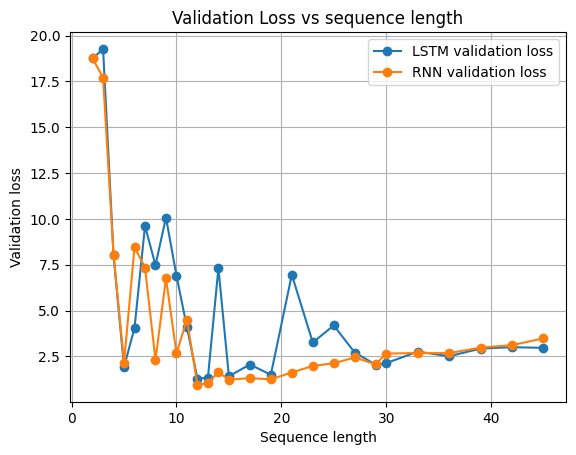

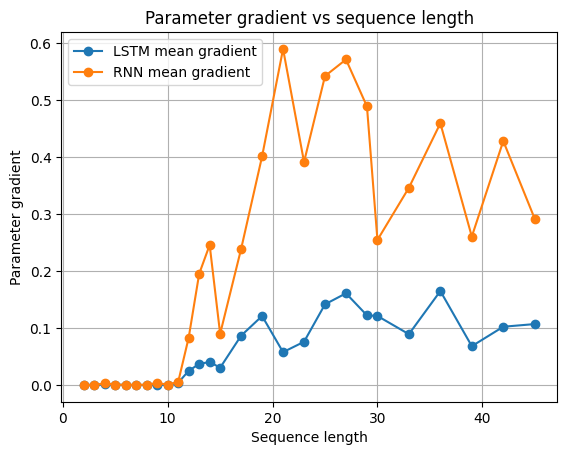

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 12) Training on realistic sequences - noisy input (standard deviation = 2)
- Unnormalized sequences (of varying lengths)

### 12.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 12.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 2)


Sequence length = 2
Correlation of target with lagged values: -
 [0.96836871 0.93068679]

Mean gradient across epochs = 0.8139578753151
Best LSTM validation loss = 0.16758255660533905

Mean gradient across epochs = 7.503637671284378
Best RNN validation loss = 0.161463662981987
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [0.95153269 0.85279853 0.86944161]

Mean gradient across epochs = 2.5697029269183984
Best LSTM validation loss = 0.1082082986831665

Mean gradient across epochs = 4.493142761476338
Best RNN validation loss = 0.7568928003311157
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.9468787  0.70530768 0.60312819 0.81291376]

Mean gradient across epochs = 0.881812307331711
Best LSTM validation loss = 0.2737879455089569

Mean gradient across epochs = 2.7444154327735304
Best RNN validation loss = 0.33422285318374634
------------------------------------

Sequence le

### 12.3) Plot MADs for varying sequences for LSTM as well as RNN

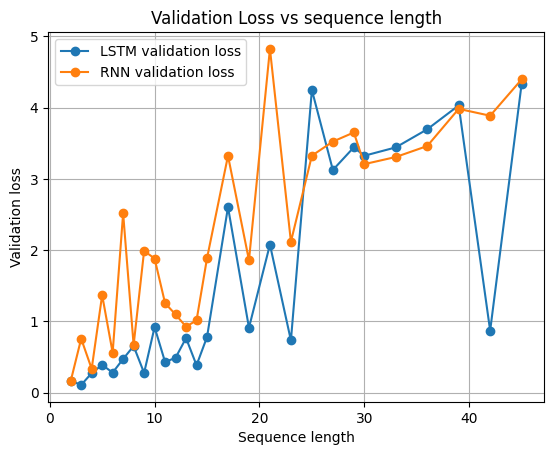

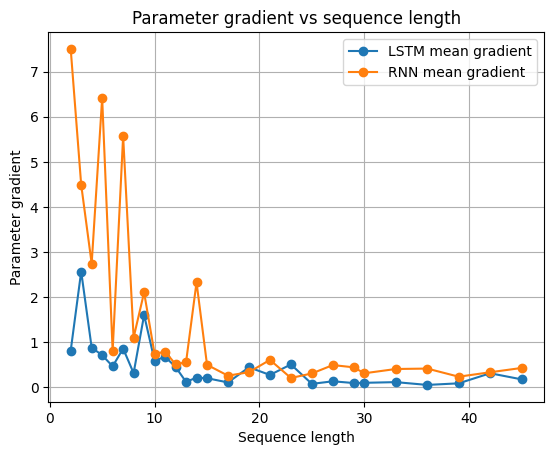

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 13) Training on realistic sequences - noisy input (standard deviation = 4)
- Unnormalized sequences (of varying lengths)

### 13.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 13.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 4)


Sequence length = 2
Correlation of target with lagged values: -
 [0.97149223 0.94576984]

Mean gradient across epochs = 0.5373086133564356
Best LSTM validation loss = 0.4829484522342682

Mean gradient across epochs = 3.0411409785971046
Best RNN validation loss = 0.591981053352356
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [0.9568595  0.8932579  0.90548568]

Mean gradient across epochs = 4.012148103397339
Best LSTM validation loss = 0.18162180483341217

Mean gradient across epochs = 3.389410125883296
Best RNN validation loss = 9.253016471862793
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.9520087  0.8243273  0.77556847 0.87607392]

Mean gradient across epochs = 1.4913879193365573
Best LSTM validation loss = 0.2794497609138489

Mean gradient across epochs = 3.1283300295472145
Best RNN validation loss = 1.7656199932098389
------------------------------------

Sequence 

### 13.3) Plot MADs for varying sequences for LSTM as well as RNN

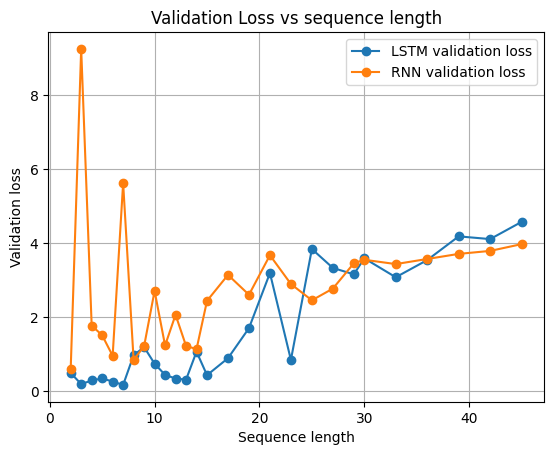

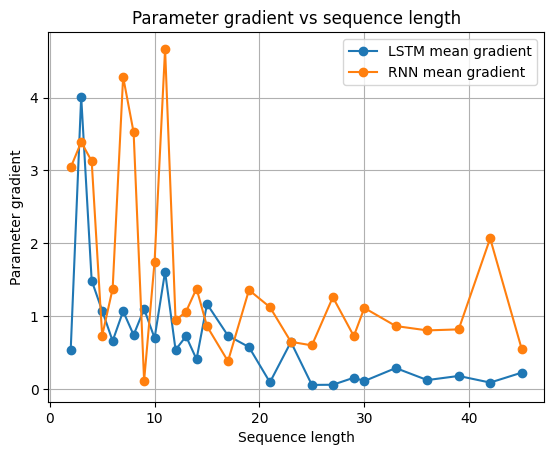

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 14) Training on realistic sequences - noisy input (standard deviation = 6)
- Unnormalized sequences (of varying lengths)

### 14.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 14.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = False, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 6)


Sequence length = 2
Correlation of target with lagged values: -
 [0.97213733 0.94828396]

Mean gradient across epochs = 1.9385773245012388
Best LSTM validation loss = 1.6311699151992798

Mean gradient across epochs = 4.6560374839231375
Best RNN validation loss = 0.10019542276859283
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [0.95802923 0.90082814 0.91201086]

Mean gradient across epochs = 0.3187933321736637
Best LSTM validation loss = 0.3312571942806244

Mean gradient across epochs = 3.6904622703208587
Best RNN validation loss = 12.684747695922852
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.95313591 0.85156676 0.81522045 0.89054516]

Mean gradient across epochs = 1.4362909165676683
Best LSTM validation loss = 1.421553611755371

Mean gradient across epochs = 2.367937383055687
Best RNN validation loss = 2.347815990447998
------------------------------------

Sequence

### 14.3) Plot MADs for varying sequences for LSTM as well as RNN

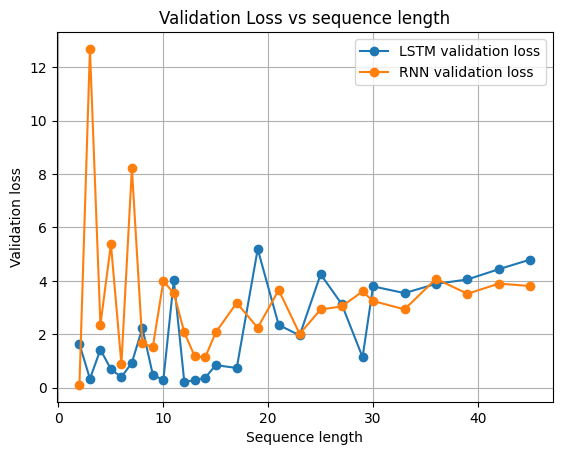

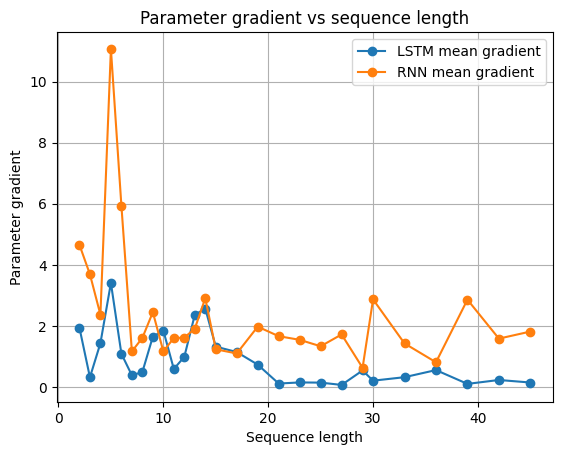

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 15) Training on realistic sequences - noise-free input
- Normalized sequences (of varying lengths)

### 15.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 15.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 0)


Sequence length = 2
Correlation of target with lagged values: -
 [ 1. -1.]

Mean gradient across epochs = 0.0022543554346214022
Best LSTM validation loss = 23.141809463500977

Mean gradient across epochs = 0.00045287895131416176
Best RNN validation loss = 26.110179901123047
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [ 0.97162556 -0.61514524 -0.56581031]

Mean gradient across epochs = 0.0002828898811443992
Best LSTM validation loss = 1.2100424766540527

Mean gradient across epochs = 3.932008793065835e-05
Best RNN validation loss = 4.82480001449585
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [ 0.9424864  -0.31162411 -0.9426028   0.18804063]

Mean gradient across epochs = 0.0029156058484346658
Best LSTM validation loss = 9.357932090759277

Mean gradient across epochs = 0.0018653531181300309
Best RNN validation loss = 9.22854232788086
------------------------------------


### 15.3) Plot MADs for varying sequences for LSTM as well as RNN

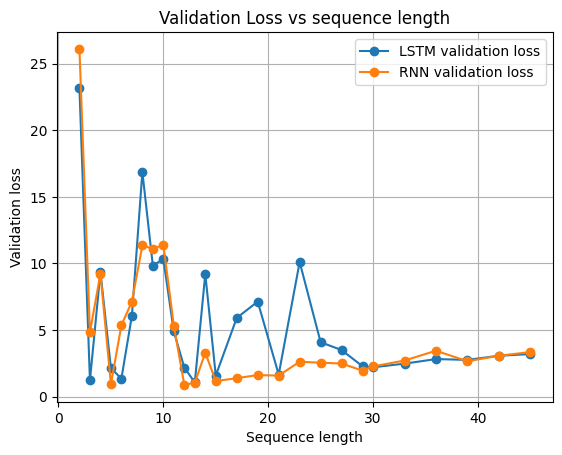

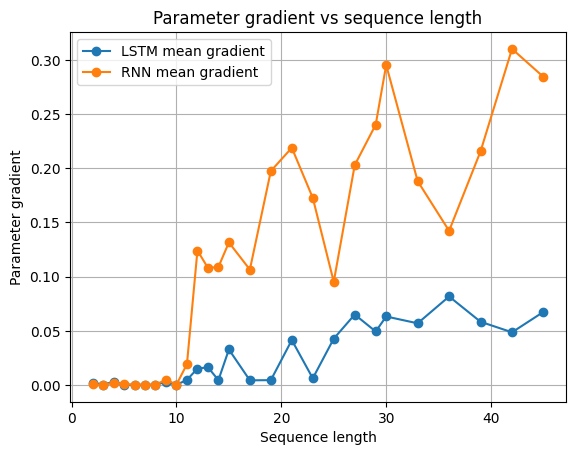

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 16) Training on realistic sequences - noisy input (standard deviation = 2)
- Normalized sequences (of varying lengths)

### 16.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 16.2) Creating input sequences, models, and training the model

In [ ]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 2)


Sequence length = 2
Correlation of target with lagged values: -
 [0.96836871 0.93068679]

Mean gradient across epochs = 0.09265488600358367
Best LSTM validation loss = 0.10682655870914459

Mean gradient across epochs = 0.8765164270997048
Best RNN validation loss = 0.031870391219854355
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [0.95153269 0.85279853 0.86944161]

Mean gradient across epochs = 0.4560404087416828
Best LSTM validation loss = 0.3235168159008026

Mean gradient across epochs = 1.4682948097586632
Best RNN validation loss = 0.1201077550649643
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.9468787  0.70530768 0.60312819 0.81291376]

Mean gradient across epochs = 0.1524087194353342
Best LSTM validation loss = 0.14121262729167938

Mean gradient across epochs = 1.0953265197575093
Best RNN validation loss = 0.3161534368991852
------------------------------------

S

### 16.3) Plot MADs for varying sequences for LSTM as well as RNN

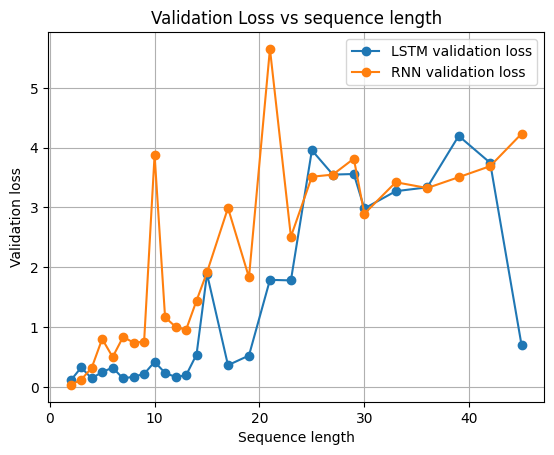

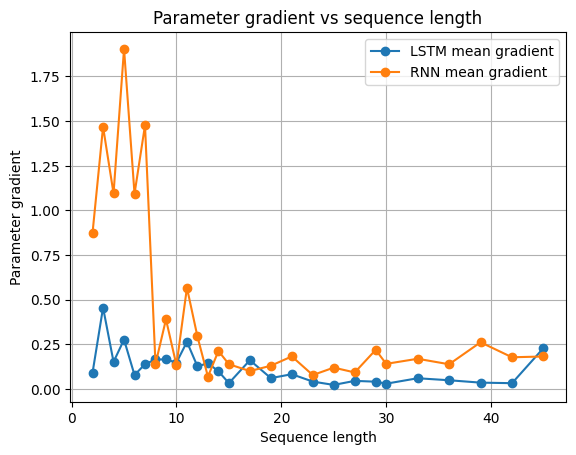

In [ ]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 17) Training on realistic sequences - noisy input (standard deviation = 4)
- Normalized sequences (of varying lengths)

### 17.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 17.2) Creating input sequences, models, and training the model

In [20]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 4)


Sequence length = 2
Correlation of target with lagged values: -
 [0.97149223 0.94576984]

Mean gradient across epochs = 0.13947353340918198
Best LSTM validation loss = 0.4697642922401428

Mean gradient across epochs = 1.68132937066257
Best RNN validation loss = 0.07663897424936295
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [0.9568595  0.8932579  0.90548568]

Mean gradient across epochs = 0.2901281422004104
Best LSTM validation loss = 0.5243239402770996

Mean gradient across epochs = 2.65212467610836
Best RNN validation loss = 0.1231396272778511
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.9520087  0.8243273  0.77556847 0.87607392]

Mean gradient across epochs = 0.431038071308285
Best LSTM validation loss = 0.062021419405937195

Mean gradient across epochs = 2.501258596405387
Best RNN validation loss = 0.18091635406017303
------------------------------------

Sequenc

### 17.3) Plot MADs for varying sequences for LSTM as well as RNN

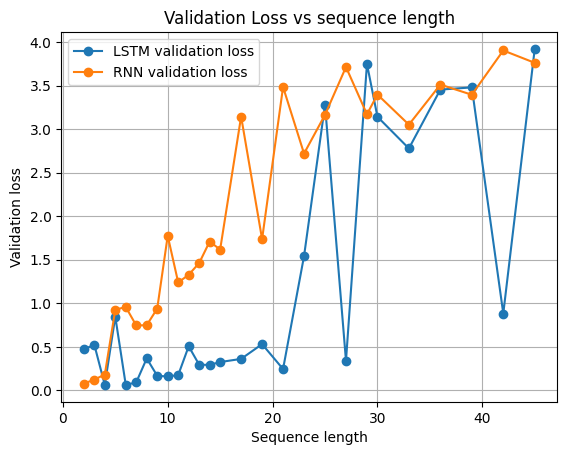

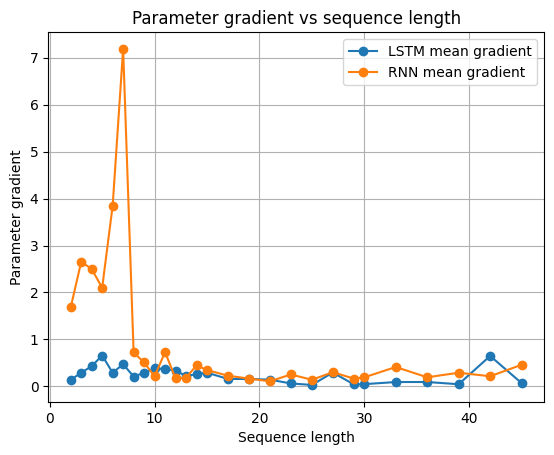

In [21]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)

## 18) Training on realistic sequences - noisy input (standard deviation = 6)
- Normalized sequences (of varying lengths)

### 18.1) Setting model parameters and hyper-parameters

Already done in 3.1)

### 18.2) Creating input sequences, models, and training the model

In [22]:
lstm_val_loss_dict, rnn_val_loss_dict, lstm_grad_dict, rnn_grad_dict = build_and_train_models_across_grid(seq_type = 'R', seq_len_list = seq_len_list, normalize = True, data_lower_lim = data_lower_lim, data_upper_lim = data_upper_lim, noise_std_dev = 6)


Sequence length = 2
Correlation of target with lagged values: -
 [0.97213733 0.94828396]

Mean gradient across epochs = 0.4162553676404059
Best LSTM validation loss = 0.1452249139547348

Mean gradient across epochs = 2.877741670794785
Best RNN validation loss = 0.1660708487033844
------------------------------------

Sequence length = 3
Correlation of target with lagged values: -
 [0.95802923 0.90082814 0.91201086]

Mean gradient across epochs = 0.951957053039223
Best LSTM validation loss = 0.17273205518722534

Mean gradient across epochs = 0.9226929463446141
Best RNN validation loss = 0.5642018914222717
------------------------------------

Sequence length = 4
Correlation of target with lagged values: -
 [0.95313591 0.85156676 0.81522045 0.89054516]

Mean gradient across epochs = 0.708425368834287
Best LSTM validation loss = 0.1806144416332245

Mean gradient across epochs = 1.622194505482912
Best RNN validation loss = 0.439849853515625
------------------------------------

Sequence l

### 18.3) Plot MADs for varying sequences for LSTM as well as RNN

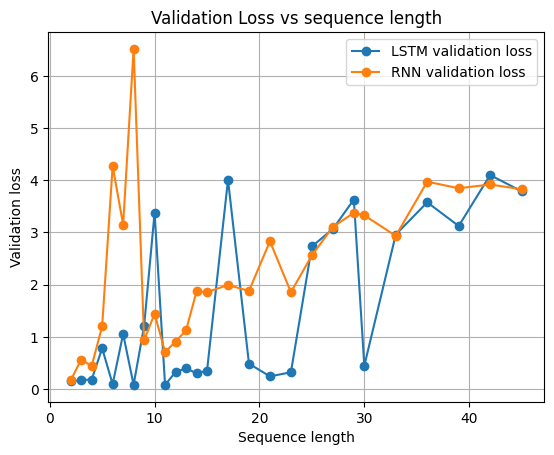

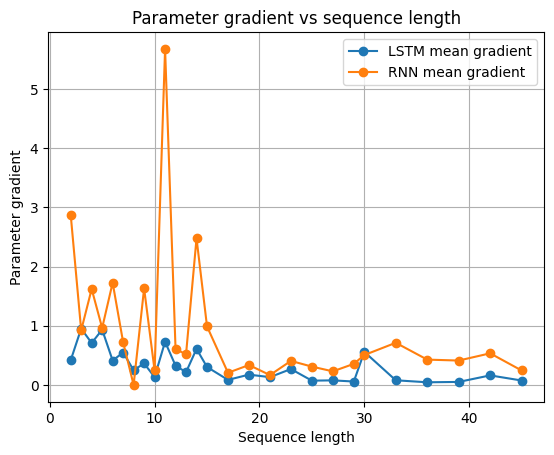

In [23]:
plot_mad(lstm_val_loss_dict, rnn_val_loss_dict)
plot_grad(lstm_grad_dict, rnn_grad_dict)